In [25]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from typing import List
import numpy as np
from sklearn.preprocessing import StandardScaler
import itertools as itertools
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
import pandas as pd

## Dataset load

In [27]:
# load training and test data set from a text file
df = pd.read_csv("./data/South African Heart Disease.txt")
# encode famhist with dummy 0-1 variable
df['famhist'] = pd.get_dummies(df['famhist'])['Present']
target = 'chd'
features = ['sbp', 'tobacco', 'ldl', 'famhist', 'obesity', 'alcohol', 'age']
df[features + [target]].head()

,sbp,tobacco,ldl,famhist,obesity,alcohol,age,chd
0,160,12.00,5.73,True,25.30,97.20,52,1
1,144,0.01,4.41,False,28.87,2.06,63,1
2,118,0.08,3.48,True,29.14,3.81,46,0
3,170,7.50,6.41,True,31.99,24.26,58,1
4,134,13.60,3.50,True,25.99,57.34,49,1


In [24]:
df

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,True,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,False,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,True,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,True,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,True,60,25.99,57.34,49,1
...,...,...,...,...,...,...,...,...,...,...,...
457,459,214,0.40,5.98,31.72,False,64,28.45,0.00,58,0
458,460,182,4.20,4.41,32.10,False,52,28.61,18.72,52,1
459,461,108,3.00,1.59,15.23,False,40,20.09,26.64,55,0
460,462,118,5.40,11.61,30.79,False,64,27.35,23.97,40,0


## pairwise plot

In [4]:
import seaborn as sns

/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/homebrew/anaconda3/envs/sklearn-env/lib/python3.12/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

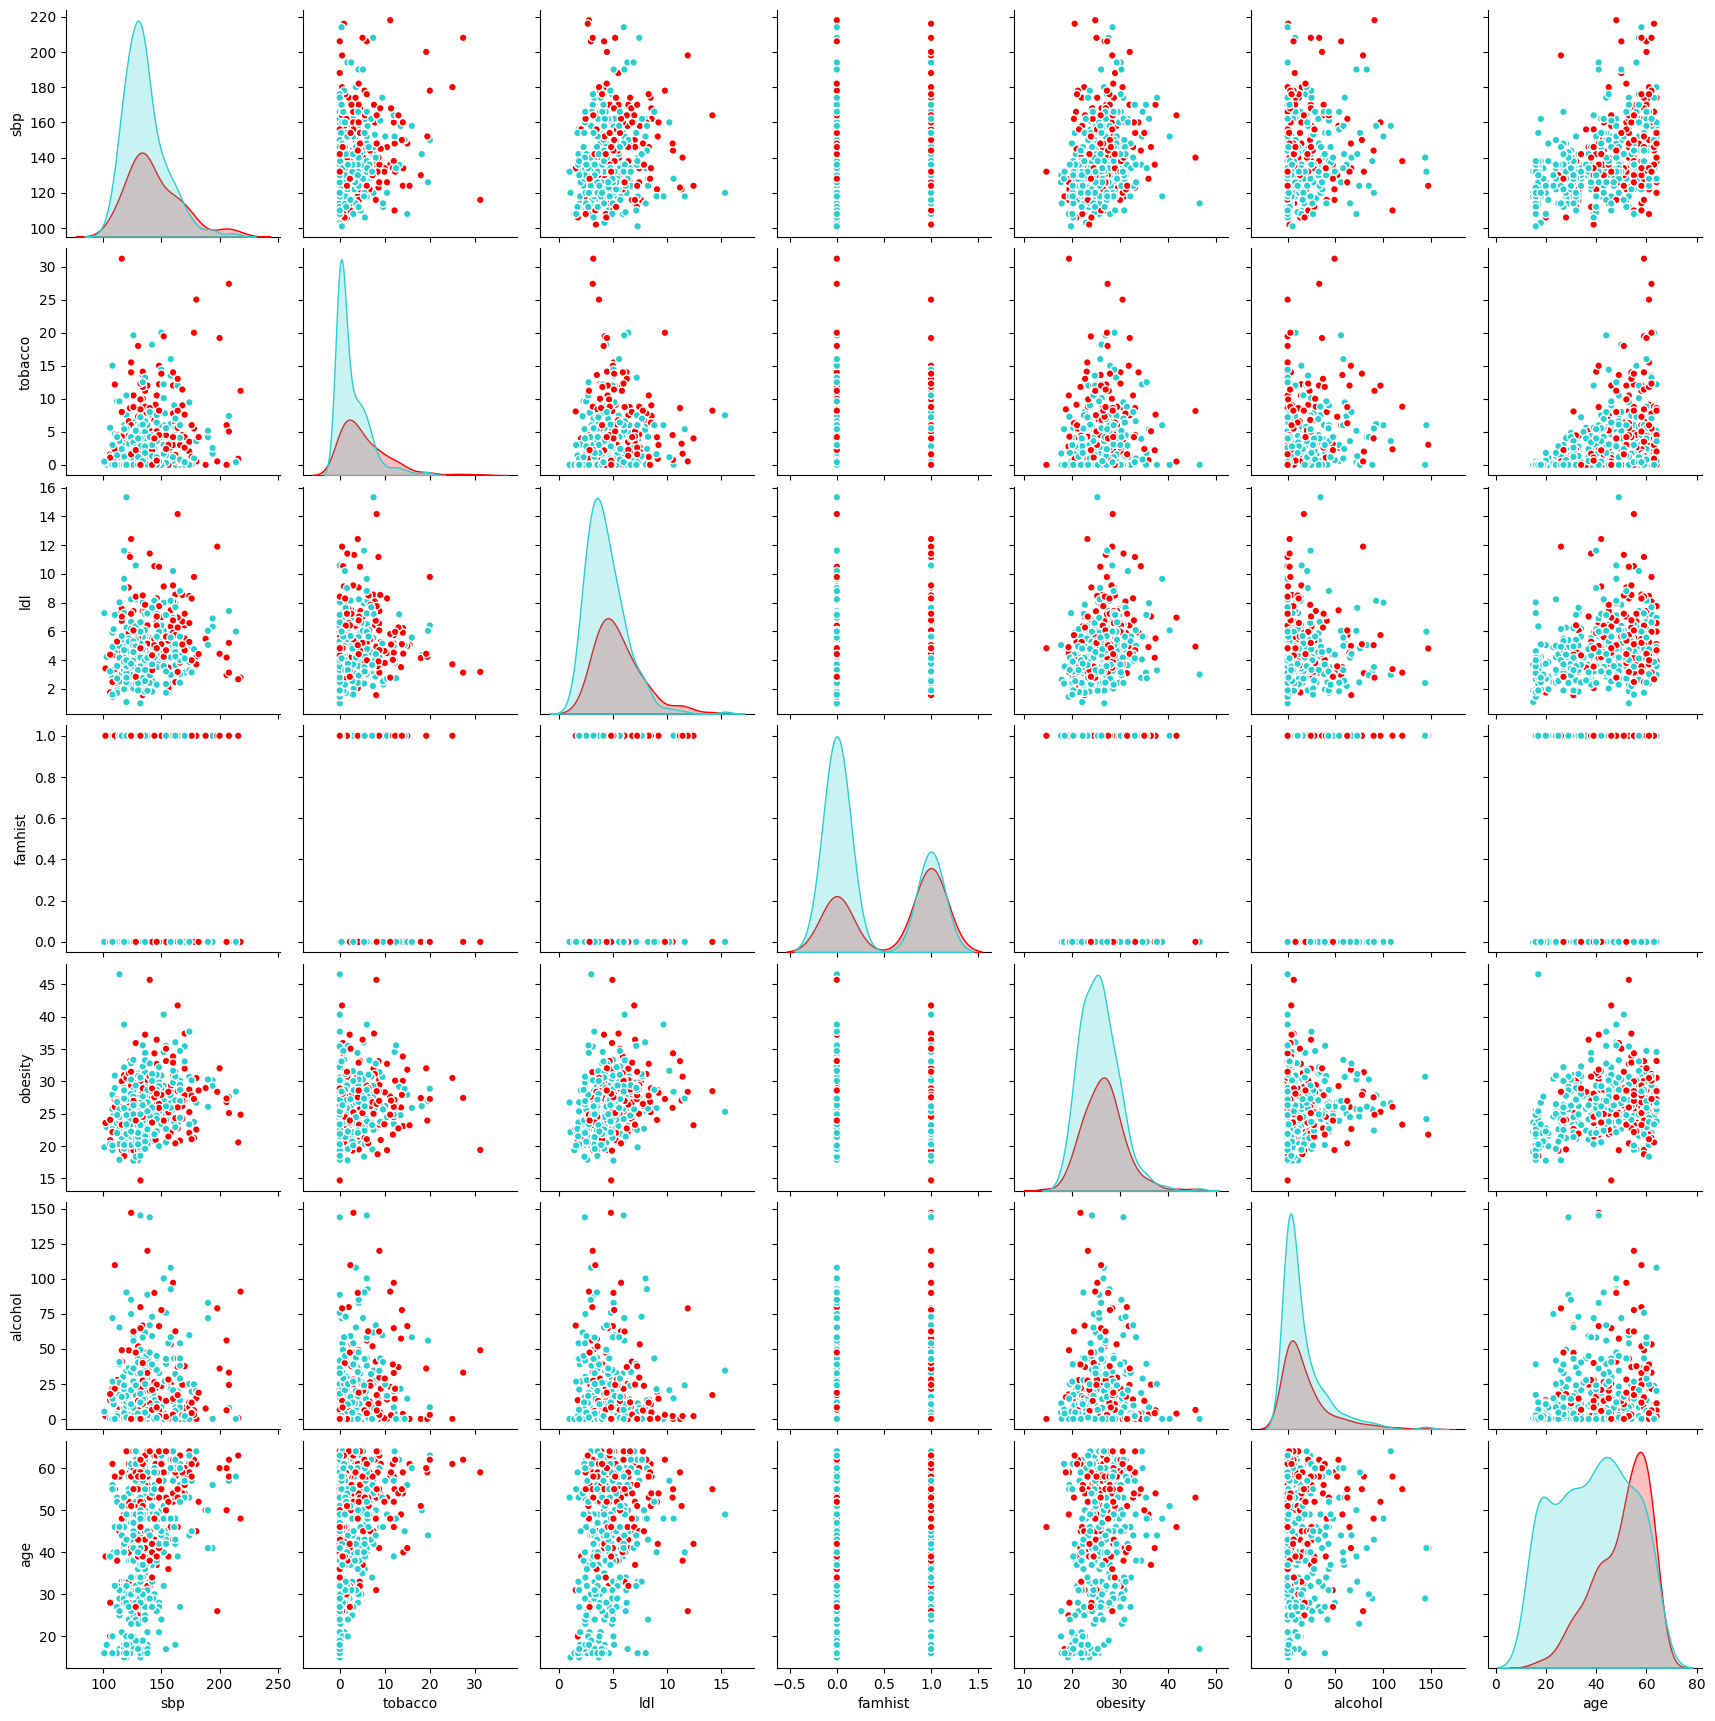

In [5]:
sns.pairplot(
    df, vars=features, kind="scatter", hue=target,
    palette=['#29CFD0', '#FF0000'], plot_kws=dict(s=30, linewidth=1)
)._legend.remove()

In [6]:
X, y = df[features].values, df[target].values

## Algorithm

In [36]:
class NaturalCubicSplineFeatures(BaseEstimator, TransformerMixin):
    """Generate natural cubic spline and interaction features.
    Parameters
    ----------
    knots :
        Is a list that contains knots list for each feature.
    add_interactions :
        If false, only natural cubic spline features are produced, otherwise
        expanded features interactions are included.
    target_dofs :
        Is a number of degrees of freedom for each feature. If is set, df+1
        knots for features would be automatically calculated at uniform
        quantiles including min and max value of a feature.
    Attributes
    ----------
    dofs_:
        The degrees of freedom for each feature.
    positions_:
        For each feature the index of the first and the last indices of its
        components."""
    def __init__(self, knots: List[List[float]]=None, target_dofs: int=None,
                 add_interactions: bool = False):
        self.knots = knots
        self.add_interactions = add_interactions
        self.target_dofs = target_dofs

    def fit(self, X: np.ndarray,
            y: np.array=None) -> 'NaturalCubicSplineFeatures':
        """Fit NaturalCubicSplineFeatures model according to the given training
           data and parameters.
        Parameters
        ----------
        X :
            Training data.
        y :
            Target values.
        """
        if self.target_dofs is not None:
            quantiles = np.linspace(0, 1, self.target_dofs + 1)
            self.knots = []
            for i in range(X.shape[1]):
                self.knots.append(np.unique(np.quantile(X[:, i], quantiles)))
        # calculate the number of parameters in each component term
        self.dofs_ = np.array([len(k)-1 for k in self.knots])
        # for each feature calculate the first and the last index of expanded
        # basis
        dofs_cumsum = [0] + list(np.cumsum(self.dofs_))
        self.positions_ = [(dofs_cumsum[i-1], dofs_cumsum[i]-1)
                           for i in range(1, len(dofs_cumsum))]
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        """Transform data to natural cubic spline basis expansion
        Parameters
        ----------
        X :
            The data to transform, row by row
        Returns
        -------
        X_new : np.ndarray, shape [n_samples, NN]
            The matrix of features, where NN is the number of natural cubic
            spline features generated from the inputs based on knots.
        """
        features_basis_splines = []
        for i in range(X.shape[1]):
            features_basis_splines.append(
                self.__expand_natural_cubic(X[:, i:i+1], self.knots[i]))
        if self.add_interactions:
            self.__add_interaction_features(features_basis_splines)
        return np.hstack(features_basis_splines)

    
    ### this method calculates the cubic spline basis expansion
    ### for multiple knots
    ### X: the input data
    ### knots: the knots for the cubic spline
    
    @staticmethod
    def __dk(X: np.ndarray, knot: float, knot_last: float) -> np.ndarray:
        return (X - knot).clip(0) ** 3 / (knot_last - knot)

    @staticmethod
    def __expand_natural_cubic(X: np.ndarray, knots: np.array) -> np.ndarray:
        basis_splines = [X]
        dk_last = NaturalCubicSplineFeatures.__dk(X, knots[-2], knots[-1])
        for knot in knots[:-2]:
            dk = NaturalCubicSplineFeatures.__dk(X, knot, knots[-1])
            basis_splines.append(dk - dk_last)
        return np.hstack(basis_splines)

    @staticmethod
    def __add_interaction_features(features_basis_splines):
        features_indices = [list(range(expansion.shape[1]))
                            for expansion in features_basis_splines]
        for combination in itertools.product(*features_indices):
            product = features_basis_splines[0][:, combination[0]].copy()
            for i in range(1, len(combination)):
                product *= features_basis_splines[i][:, combination[i]]
            features_basis_splines.append(np.atleast_2d(product).T)

In [98]:
# PAGE 146. We use four natural spline bases for each term in the model. For
#           example, with X1 representing sbp, h1(X1) is a basis consisting of
#           four basis functions. This actually implies three rather than two
#           interior knots (chosen at uniform quantiles of sbp), plus two
#           boundary knots at the extremes of the data, since we exclude the
#           constant term from each of the hj.
ncs_features = NaturalCubicSplineFeatures(target_dofs=4)
add_intercept_fn = FunctionTransformer(
    lambda X: sm.add_constant(X), validate=True)
data_prep_pipeline = Pipeline([('scale_features', StandardScaler()),
                               ('expand_basis', ncs_features),
                               ('scale_basis', StandardScaler()),
                               ('add_intercept_column', add_intercept_fn)])

# # PAGE 146. At this point the model is like any other linear logistic model,
# #           and the algorithms described in Section 4.4.1 apply
# lr = LogisticRegression(
#     solver='lbfgs', max_iter=100000, C=10e10, fit_intercept=False)
# expanded_lr = Pipeline([('prepare', data_prep_pipeline),
#                         ('logistic', lr)])

In [103]:
add_intercept_fn.fit_transform(X)

array([[1.000e+00, 1.600e+02, 1.200e+01, ..., 2.530e+01, 9.720e+01,
        5.200e+01],
       [1.000e+00, 1.440e+02, 1.000e-02, ..., 2.887e+01, 2.060e+00,
        6.300e+01],
       [1.000e+00, 1.180e+02, 8.000e-02, ..., 2.914e+01, 3.810e+00,
        4.600e+01],
       ...,
       [1.000e+00, 1.080e+02, 3.000e+00, ..., 2.009e+01, 2.664e+01,
        5.500e+01],
       [1.000e+00, 1.180e+02, 5.400e+00, ..., 2.735e+01, 2.397e+01,
        4.000e+01],
       [1.000e+00, 1.320e+02, 0.000e+00, ..., 1.470e+01, 0.000e+00,
        4.600e+01]])

In [73]:
ncs_features.

AttributeError: 'NaturalCubicSplineFeatures' object has no attribute '__expand_natural_cubic'

In [58]:
target_dofs = 4
if target_dofs is not None:
    quantiles = np.linspace(0, 1, target_dofs + 1)
    print(quantiles)
    knots = []
    for i in range(X.shape[1]):
        knots.append(np.unique(np.quantile(X[:, i], quantiles)))
# calculate the number of parameters in each component term
dofs_ = np.array([len(k)-1 for k in knots])
# for each feature calculate the first and the last index of expanded
# basis
dofs_cumsum = [0] + list(np.cumsum(dofs_))
positions_ = [(dofs_cumsum[i-1], dofs_cumsum[i]-1)
                    for i in range(1, len(dofs_cumsum))]

[0.   0.25 0.5  0.75 1.  ]


In [78]:
knots

[array([101.0, 124.0, 134.0, 148.0, 218.0], dtype=object),
 array([0.0, 0.052500000000000005, 2.0, 5.5, 31.2], dtype=object),
 array([0.98, 3.2824999999999998, 4.34, 5.79, 15.33], dtype=object),
 array([0.0, 1.0], dtype=object),
 array([14.7, 22.985, 25.805, 28.4975, 46.58], dtype=object),
 array([0.0, 0.51, 7.51, 23.8925, 147.19], dtype=object),
 array([15.0, 31.0, 45.0, 55.0, 64.0], dtype=object)]

In [61]:
dofs_

array([4, 4, 4, 1, 4, 4, 4])

In [67]:
dofs_cumsum 

[0, 4, 8, 12, 13, 17, 21, 25]

In [68]:
positions_

[(0, 3), (4, 7), (8, 11), (12, 12), (13, 16), (17, 20), (21, 24)]

In [85]:

def dk_calc(X: np.ndarray, knot: float, knot_last: float) -> np.ndarray:
    return (X - knot).clip(0) ** 3 / (knot_last - knot)

def expand_natural_cubic(X: np.ndarray, knots: np.array) -> np.ndarray:
    basis_splines = [X]
    dk_last = dk_calc(X, knots[-2], knots[-1])
    print(dk_last)
    for knot in knots[:-2]:
        dk = dk_calc(X, knot, knots[-1])
        basis_splines.append(dk - dk_last)
    return np.hstack(basis_splines)

def add_interaction_features(features_basis_splines):
    features_indices = [list(range(expansion.shape[1]))
                        for expansion in features_basis_splines]
    for combination in itertools.product(*features_indices):
        product = features_basis_splines[0][:, combination[0]].copy()
        for i in range(1, len(combination)):
            product *= features_basis_splines[i][:, combination[i]]
        features_basis_splines.append(np.atleast_2d(product).T)

## Basis will be calculated for each feature


For each feature, the basis will be calculated by the following formula:

$ dk = (x - knot)^{3}\div(knot_{last} - knot) $

For 4 degrees of freedom, now a N x 1 dimensional feature vector becomes N x 4 dimensional feature vector.



In [93]:
knots[i]

array([101.0, 124.0, 134.0, 148.0, 218.0], dtype=object)

In [95]:
i = 0
expanded_basis = expand_natural_cubic(X[:, i:i+1], knots[i])

[[24.685714285714287]
 [0.0]
 [0.0]
 [152.11428571428573]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [2787.3142857142857]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [14.285714285714286]
 [0.0]
 [0.0]
 [0.0]
 [0.11428571428571428]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [14.285714285714286]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [39.2]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.9142857142857143]
 [0.0]
 [7.314285714285714]
 [0.9142857142857143]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.9142857142857143]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [114.28571428571429]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [1390.5142857142857]
 [0.0]
 [0.0]
 [0.0]
 [0.0]
 [58.51428571428571]
 [0.0]
 [83.31428571428572]
 [0.0]
 [0.0]
 [0.0]
 [14.285714285714286]
 [0.0]
 [152.11428571428573]
 [0.0

In [96]:
expanded_basis

array([[160, 1730.690354090354, 471.6547112462006, 184.55238095238096],
       [144, 679.5470085470085, 85.1063829787234, 11.904761904761905],
       [118, 41.99145299145299, 0.0, 0.0],
       ...,
       [108, 2.9316239316239314, 0.0, 0.0],
       [118, 41.99145299145299, 0.0, 0.0],
       [132, 254.6239316239316, 5.446808510638298, 0.0]], dtype=object)

In [38]:
selected_ids = set(range(len(features)))
X_selected = X[:, sorted(list(selected_ids))]
# expand the basis of the selected features
X_selected_exp = data_prep_pipeline.fit_transform(X_selected)

In [35]:
df

,row.names,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,True,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,False,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,True,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,True,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,True,60,25.99,57.34,49,1
...,...,...,...,...,...,...,...,...,...,...,...
457,459,214,0.40,5.98,31.72,False,64,28.45,0.00,58,0
458,460,182,4.20,4.41,32.10,False,52,28.61,18.72,52,1
459,461,108,3.00,1.59,15.23,False,40,20.09,26.64,55,0
460,462,118,5.40,11.61,30.79,False,64,27.35,23.97,40,0


In [33]:
X

array([[160, 12.0, 5.73, ..., 25.3, 97.2, 52],
       [144, 0.01, 4.41, ..., 28.87, 2.06, 63],
       [118, 0.08, 3.48, ..., 29.14, 3.81, 46],
       ...,
       [108, 3.0, 1.59, ..., 20.09, 26.64, 55],
       [118, 5.4, 11.61, ..., 27.35, 23.97, 40],
       [132, 0.0, 4.82, ..., 14.7, 0.0, 46]], dtype=object)

In [30]:
X_selected

array([[160, 12.0, 5.73, ..., 25.3, 97.2, 52],
       [144, 0.01, 4.41, ..., 28.87, 2.06, 63],
       [118, 0.08, 3.48, ..., 29.14, 3.81, 46],
       ...,
       [108, 3.0, 1.59, ..., 20.09, 26.64, 55],
       [118, 5.4, 11.61, ..., 27.35, 23.97, 40],
       [132, 0.0, 4.82, ..., 14.7, 0.0, 46]], dtype=object)

In [11]:
# calculates AIC of log-reg model trained on expanded features subset
def subset_aic(selected_ids):
    X_selected = X[:, sorted(list(selected_ids))]
    # expand the basis of the selected features
    X_selected_exp = data_prep_pipeline.fit_transform(X_selected)
    # fit the log-reg model to the expanded data and calculate its AIC
    lr = sm.Logit(
        y, X_selected_exp
    ).fit_regularized(method='l1', maxiter=1000, disp=False)
    return lr.aic

# calculates total deviance of a model on a data set
def deviance(X, y, model):
    return 2*log_loss(y, model.predict_proba(X), normalize=False)


# calculates total deviance of a model trained on features subset
def subset_deviance(model, selected_ids):
    X_selected = X[:, sorted(list(selected_ids))]
    model.fit(X_selected, y)
    return deviance(X_selected, y, model)

# start with all features selected, store indices
selected_ids = set(range(len(features)))
current_aic = subset_aic(selected_ids)
current_deviance = subset_deviance(lr, selected_ids)
while True:
    stat = [(subset_aic(selected_ids - set([idx])),
             subset_deviance(expanded_lr, selected_ids - set([idx])),
             idx) for idx in selected_ids]
    min_aic, dev, feature_to_remove_idx = min(stat)
    if min_aic > current_aic:
        break
    selected_ids -= set([feature_to_remove_idx])
    current_aic, current_deviance = min_aic, dev
    print(f'REMOVE: {features[feature_to_remove_idx]}')

selected_ids = sorted(list(selected_ids))
# convert list of stats to dictionary
stat = {id: (aic, dev) for (aic, dev, id) in stat}

REMOVE: alcohol


## How does the algorithm of natural splines work?
